In [39]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines

In [28]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)

In [2]:
from astropy.table import Table
import assemble_catalog

cat = Table(assemble_catalog.assemble_catalog(assemble_catalog.default_root_dirname, 
                                       assemble_catalog.default_num_subvols,
                                       'halo_id', 'stellar_mass', 'sfr', 'halo_upid', 'sfr_mp', 'sm_mp'))

cat['ssfr'] = cat['sfr']/cat['stellar_mass']

In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck', redshift=0)
num_halos = len(halocat.halo_table)

In [4]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(cat['halo_id'], halocat.halo_table['halo_id'])
cat = cat[idxA]

cat['halo_scale_factor_firstacc'] = halocat.halo_table['halo_scale_factor_firstacc'][idxB]
cat['halo_mvir_host_halo'] = halocat.halo_table['halo_mvir_host_halo'][idxB]

In [14]:
satmask = cat['halo_upid'] != -1
sats = cat[satmask]
cens = cat[~satmask]

In [84]:
from satellite_quenching_efficiency import satellite_quenching_efficiency, build_matching_central_lookup_table

logsm_bins = np.linspace(9.5, 11, 12)
sm_mids = 0.5*(logsm_bins[:-1] + logsm_bins[1:])
cen_lookup_table, lookup_table_counts = build_matching_central_lookup_table(cens['sm_mp'], 
                                                                            cens['ssfr']<=10**-11, logsm_bins)

In [85]:
from satellite_quenching_efficiency import satellite_quenching_efficiency

satellite_time_indices = np.digitize(sats['halo_scale_factor_firstacc'], scale_factor_array)
satellite_time_indices[satellite_time_indices >= len(scale_factor_array)-1] = len(scale_factor_array)-1

satmask_m12_m125 = (sats['halo_mvir_host_halo'] > 10**12) & (sats['halo_mvir_host_halo'] < 10**12.5)
satmask_m125_m13 = (sats['halo_mvir_host_halo'] > 10**12.5) & (sats['halo_mvir_host_halo'] < 10**13)
satmask_m13_m135 = (sats['halo_mvir_host_halo'] > 10**13) & (sats['halo_mvir_host_halo'] < 10**13.5)
satmask_m135_m14 = (sats['halo_mvir_host_halo'] > 10**13.5) & (sats['halo_mvir_host_halo'] < 10**14)
satmask_m15 = (sats['halo_mvir_host_halo'] > 10**14)

fq_sat_m12_m125, fq_matching_cen_m12_m125 = satellite_quenching_efficiency(sats['sm_mp'][satmask_m12_m125], 
                                sats['stellar_mass'][satmask_m12_m125], 
                                satellite_time_indices[satmask_m12_m125], sats['ssfr'][satmask_m12_m125] < 10**-11, 
                                cen_lookup_table, lookup_table_counts, logsm_bins)

fq_sat_m125_m13, fq_matching_cen_m125_m13 = satellite_quenching_efficiency(sats['sm_mp'][satmask_m125_m13], 
                                sats['stellar_mass'][satmask_m125_m13], 
                                satellite_time_indices[satmask_m125_m13], sats['ssfr'][satmask_m125_m13] < 10**-11, 
                                cen_lookup_table, lookup_table_counts, logsm_bins)

fq_sat_m13_m135, fq_matching_cen_m13_m135 = satellite_quenching_efficiency(sats['sm_mp'][satmask_m13_m135], 
                                sats['stellar_mass'][satmask_m13_m135], 
                                satellite_time_indices[satmask_m13_m135], sats['ssfr'][satmask_m13_m135] < 10**-11, 
                                cen_lookup_table, lookup_table_counts, logsm_bins)

fq_sat_m135_m14, fq_matching_cen_m135_m14 = satellite_quenching_efficiency(sats['sm_mp'][satmask_m135_m14], 
                                sats['stellar_mass'][satmask_m135_m14], 
                                satellite_time_indices[satmask_m135_m14], sats['ssfr'][satmask_m135_m14] < 10**-11, 
                                cen_lookup_table, lookup_table_counts, logsm_bins)

fq_sat_m15, fq_matching_cen_m15 = satellite_quenching_efficiency(sats['sm_mp'][satmask_m15], 
                                sats['stellar_mass'][satmask_m15], 
                                satellite_time_indices[satmask_m15], sats['ssfr'][satmask_m15] < 10**-11, 
                                cen_lookup_table, lookup_table_counts, logsm_bins)


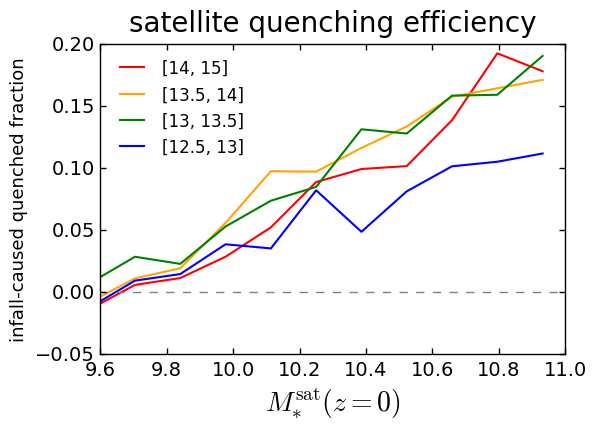

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'$M^{\rm sat}_{\ast}(z=0)$', fontsize=20)
ylabel = ax.set_ylabel(r'infall-caused quenched fraction', fontsize=13)
title = ax.set_title('satellite quenching efficiency', fontsize=20, y=1.02) # y param fixes an overhanging title

lw = 1.5
ax.plot(sm_mids, fq_sat_m15 - fq_matching_cen_m15, 
        color='red', label='[14, 15]', linewidth=lw)
ax.plot(sm_mids, fq_sat_m135_m14 - fq_matching_cen_m135_m14, 
        color='orange', label='[13.5, 14]', linewidth=lw)
ax.plot(sm_mids, fq_sat_m13_m135 - fq_matching_cen_m13_m135, 
        color='green', label='[13, 13.5]', linewidth=lw)
ax.plot(sm_mids, fq_sat_m125_m13 - fq_matching_cen_m125_m13, 
        color='blue', label='[12.5, 13]', linewidth=lw)
# ax.plot(sm_mids, fq_sat_m12_m125 - fq_matching_cen_m12_m125, 
#         color='magenta', label='[12, 12.5]', linewidth=lw)

ax.plot(np.arange(100), np.zeros(100), '--', color='gray', linewidth=1)

plt.xlim(xmin = 9.6, xmax=11)
plt.ylim(ymin = -0.05, ymax = 0.2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='upper left', fontsize=12)

fig.savefig('FIGS/satellite_quenching_efficiency.pdf', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [64]:
fq_sat_m15 - fq_matching_cen_m15

array([-0.24999485, -0.23937563, -0.21552379, -0.18518997, -0.19520934,
       -0.16583273, -0.13484886, -0.08615769, -0.10348085, -0.06914886,
        0.05532437])